# MC Simulation of Electrons in a Conductor

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kde, chisquare, norm
from scipy.optimize import curve_fit

In [8]:
ElectronCharge = 1.6e-19 # [C]
Boltzmann = 1.38e-23 # [m^2 kg s^-2 k^-1]
CoulombConstant = 8.9875517923e+9

SphereRadius = 1e-7 # [m]
Temperature = 300 # [K]

In [9]:
def signedLog(arr:np.ndarray):
    """
    Performs a signed log: sign(x)*log(1+|x|) .
    
    Inputs:
        - arr:np.ndarray: Array to log.
    Outputs:
        - logArr:np.ndarray: The logged array.
    
    
    """
    
    signs = 2*(arr>0) - 1
    
    return signs*np.log(1 + abs(arr))



In [10]:
class DataAnalysis:
    def __init__(self):
        self.numElectrons = 1000
        self.externalCharge_x = -1.5*SphereRadius
        self.externalIncrease = 1e+2
        
        # Load positions
        with open(r"data\positions.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            lines = [line.split(',') for line in file]

        self.positions = np.asarray(lines, dtype=float)
        
        # Load energyHistory
        with open(r"data\energyHistory.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            line = file.readline()
            
        self.energyHistory = np.asarray(line.split(',')[:-1], dtype=float)
        
    def displaySphericalPotential(self, potIncrease:float):
        """
        Display the potential outside of the sphere.
        
        Inputs:
            - potIncrease:float: The constant in the exponential governing the increase of the potential.
        """
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Create potential plot
        r = np.linspace(-1.55*SphereRadius, 1.1*SphereRadius, 100)
        potential =- CoulombConstant*(np.exp(abs(abs(r) - SphereRadius)/potIncrease) - 1)
        potential[abs(r)<=SphereRadius] = 0
        
        potential += CoulombConstant*self.externalIncrease*ElectronCharge*self.numElectrons / abs(r - self.externalCharge_x)
        
        ax.grid()
        ax.plot(r, potential, color='orange')
        ax.axvline(-SphereRadius, color='green')
        ax.axvline(SphereRadius, color='green')
        
        # Creates appropiate labels
        ax.set_xlabel('radius / r [m]')
        ax.set_ylabel('potential / V [J/C]')
        ax.set_title('Variation of potential with radius')
        
        plt.show(fig)
        
        
    def displayElectrons(self):
        """
        Displays all electrons and electron density plot.
        """
        
        x = self.positions[:,0]
        y = self.positions[:,1]
        
        
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        
        
        ax.grid()
        # Create external charge
        ax.scatter(-1.5*SphereRadius, 0, color='red')
        # Creates sphere
        theta = np.linspace(0, 2*np.pi, 1000)
        ax.plot(SphereRadius*np.cos(theta), SphereRadius*np.sin(theta), color='orange')
        # Plots electron positions
        # https://stackoverflow.com/questions/39753282/scatter-plot-with-single-pixel-marker-in-matplotlib
        ax.scatter(x, y, marker='.', s=(72./fig.dpi)**2)
        
        # Creates appropiate labels
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_title('Positions of all electrons')
        
        
        plt.show(fig)
        
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        
        # Create external charge
        ax.scatter(-1.5*SphereRadius, 0, color='red')
        # Create sphere
        ax.plot(SphereRadius*np.cos(theta), SphereRadius*np.sin(theta), color='orange')
        
        ######### https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/ ##########
        nbins = 20


        K = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = K(np.vstack([xi.flatten(), yi.flatten()]))*ElectronCharge # [C/m^2]
        axesRanges = (x.min(), x.max(), y.min(), y.max())
        ratio = 1#(axesRanges[1] - axesRanges[0]) / (axesRanges[3] - axesRanges[2])


        # Creates contour plot
        im = ax.imshow(zi.reshape(xi.shape).T, cmap='Blues',
                       origin='lower', extent=axesRanges, aspect=ratio, interpolation='bicubic')
        ax.contour(xi, yi, zi.reshape(xi.shape), 4, colors='yellow', alpha=0.5, origin='lower' )
        cbar = plt.colorbar(im)
        #########################
        
        # Creates appropiate labels
        cbar.ax.set_ylabel(r'charge density / $\sigma$ [$Cm^{-2}$]')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_title('Density of electrons')

        
        plt.show(fig)
        
        
    def displayEnergyHistory(self, Nsteps:int):
        """
        Displays the history of the total energy of the system.
        
        Inputs:
            - Nsteps:int: The number of MC steps.
        """
        
        energyHistory_eV = self.energyHistory/ElectronCharge
        
        fig = plt.figure(figsize=(6,6), tight_layout=True)
        ax = fig.add_subplot(111)
        steps = np.arange(0, Nsteps, 1)
        ax.grid()
        ax.plot(steps, energyHistory_eV)
        
        # Create appropiate labels
        ax.set_xlabel('step')
        ax.set_ylabel('system energy / E [ev]')
        ax.set_title('Variation of the total energy\n of the system with MC steps')
        
        plt.show(fig)
        
        
    def potentialProfile(self, potIncrease:float):
        """
        Generates a colourmap of the potential.
        
        Inputs:
            - potIncrease:float: The constant in the exponential governing the increase of the potential.
        """
        
        numSamples = 100
        limitRatio = 1.1
        
        xSmall = np.linspace(-limitRatio*SphereRadius, limitRatio*SphereRadius, numSamples)
        xLarge = np.linspace(limitRatio*self.externalCharge_x, limitRatio*SphereRadius, numSamples)
        y = np.linspace(-limitRatio*SphereRadius, limitRatio*SphereRadius, numSamples)
        
        x2D,y2D = np.meshgrid(xSmall,y)
        
        # Add potential due to external charge
        potentialLarge = (CoulombConstant*self.externalIncrease*ElectronCharge*self.numElectrons 
                     / np.hypot(x2D - self.externalCharge_x, y2D))
        
        # Add potential due to electrons
        potentialSmall = 0
        for coord in self.positions:
            potentialSmall -= CoulombConstant*ElectronCharge/np.hypot(coord[0] - x2D, coord[1] - y2D)
            

        # Add external potential
        x2D_large, y2D_large = np.meshgrid(xLarge, y)
        r2D_large = np.hypot(x2D_large,y2D_large)
        larger = np.where(r2D_large > SphereRadius)
        potentialLarge[larger] -= CoulombConstant*(np.exp(abs(r2D_large - SphereRadius)/potIncrease) - 1)[larger]
            
        fig = plt.figure(figsize=(12,6), tight_layout=True, dpi=200)
        ax = fig.add_subplot(1,2,1)
        
        # Generate potential plot
        axesRanges = (xSmall.min(), xSmall.max(), y.min(), y.max())
        ratio = (axesRanges[1] - axesRanges[0]) / (axesRanges[3] - axesRanges[2])
        im = ax.imshow(potentialSmall, cmap='Blues', extent=axesRanges, interpolation='gaussian', aspect=1)
        cbar = plt.colorbar(im)
        cbar.ax.set_ylabel(r'potential / V [$JC^{-1}$]')
        
        # Create appropiate labels
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_title('Conductor potential')
        
        ax = fig.add_subplot(1,2,2)
        
        # Generate potential plot
        axesRanges = (xLarge.min(), xLarge.max(), y.min(), y.max())
        ratio = (axesRanges[1] - axesRanges[0]) / (axesRanges[3] - axesRanges[2]) / 1.25
        im = ax.imshow(potentialLarge, cmap='Oranges', extent=axesRanges, interpolation='bicubic', aspect=ratio)
        cbar = plt.colorbar(im)
        cbar.ax.set_ylabel(r'potential / V [$JC^{-1}$]')
        im.set_clim(0,np.max(potentialLarge))
        
        # Create appropiate labels
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_title('Space potential')
        
        plt.show(fig)
        
        
    def axisDensity(self):
        """
        Displays the density of electrons across each of the axis.
        """
        
        numBins = 50
        
        counts_x, bins_x = np.histogram(self.positions[:,0], bins=numBins, density=False)
        counts_y, bins_y = np.histogram(self.positions[:,1], bins=numBins, density=False)
        
        
        
        fig = plt.figure(figsize=(12,8), tight_layout=True)
        fig.suptitle('Number of electrons along each axis')
        
        # X dependence graph
        # Linear fit
        poly_1 = lambda x, a, b: a*x + b
        binsCentre_x = (bins_x + np.roll(bins_x, -1))[:-1] / 2
        var1, cvm1 = curve_fit(poly_1, binsCentre_x, counts_x)
        expected_1 = poly_1(binsCentre_x, var1[0], var1[1])
        normExpected_1 = expected_1 / np.sum(expected_1)*np.sum(counts_x)
        print('Linear')
        print(var1)
        chi_squared1 = chisquare(counts_x, normExpected_1, 2)
        print(chi_squared1)
        
        print('\n')
        # Inverse linear fit
        inverse_1 = lambda x, a, b, dx: a/(x - dx) + b
        binsCentre_x = (bins_x + np.roll(bins_x, -1))[:-1] / 2
        var2, cvm2 = curve_fit(inverse_1, binsCentre_x, counts_x, [1e-7, 0, -1e-7])
        expected_2 = inverse_1(binsCentre_x, var2[0], var2[1], var2[2])
        normExpected_2 = expected_2 / np.sum(expected_2)*np.sum(counts_x)
        print('Inverse linear')
        print(var2)
        chi_squared2 = chisquare(counts_x, normExpected_2, 3)
        print(chi_squared2)
        
        ax = fig.add_subplot(1,2,1)
        ax.hist(bins_x[:-1], bins_x, weights=counts_x, color='lime',density=False)
        ax.plot(binsCentre_x, normExpected_1)
        ax.plot(binsCentre_x, normExpected_2)
        
        # Creates appropiate labels
        ax.set_xlabel('x [m]')
        ax.set_ylim(0)
        ax.set_ylabel('frequency')
        
        # Y dependence graph
        binsCentre_y = (bins_y + np.roll(bins_y, -1))[:-1] / 2
        
        ys = np.linspace(-SphereRadius,SphereRadius,numBins)
        std_y = np.std(self.positions[:,1])
        mean_y = np.mean(self.positions[:,1])
        
        gaussian = norm.pdf(ys, mean_y, std_y)
        normGaussian = gaussian*np.sum(counts_y) / np.sum(gaussian)
        chi_squared_gaussian = chisquare(counts_y, normGaussian)
        print('\nGaussian')
        print(mean_y, std_y)
        print(chi_squared_gaussian)
        
        ax = fig.add_subplot(1,2,2)
        ax.hist(bins_y[:-1], bins_y, weights=counts_y, color='cyan',density=True)
        ax.plot(ys, gaussian)
        
        # Creates appropiate labels
        ax.set_xlabel('y [m]')
        ax.set_ylabel('frequency')
        
        plt.show(fig)


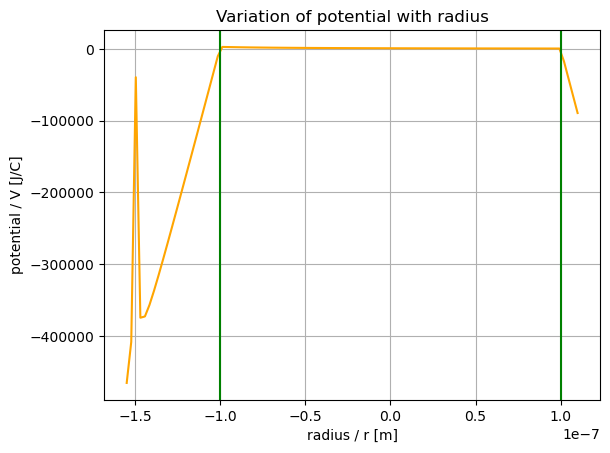

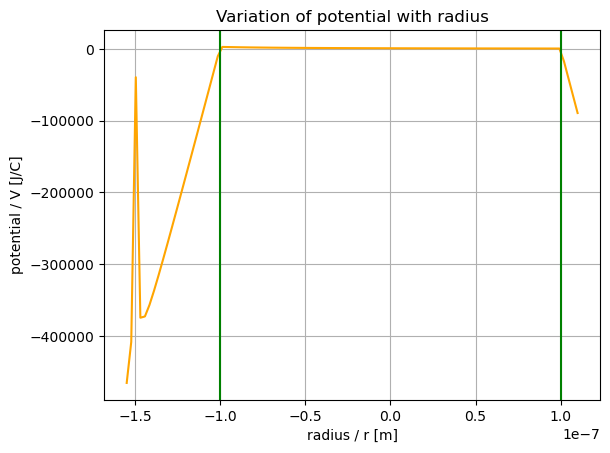

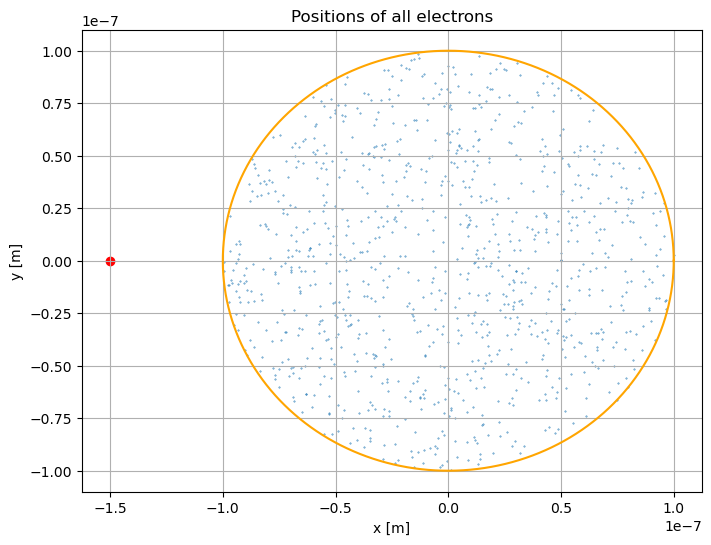

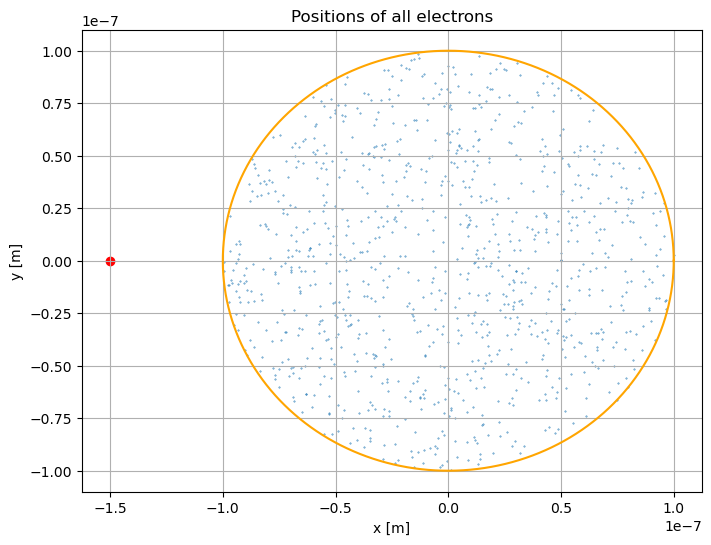

C:\Users\02dba\AppData\Local\Temp\ipykernel_50140\1265702639.py:97: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  K = kde.gaussian_kde([x, y])
C:\Users\02dba\AppData\Local\Temp\ipykernel_50140\1265702639.py:97: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  K = kde.gaussian_kde([x, y])


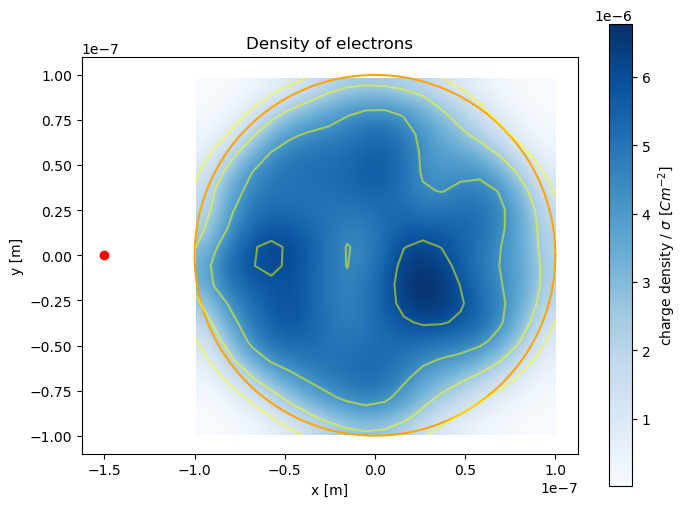

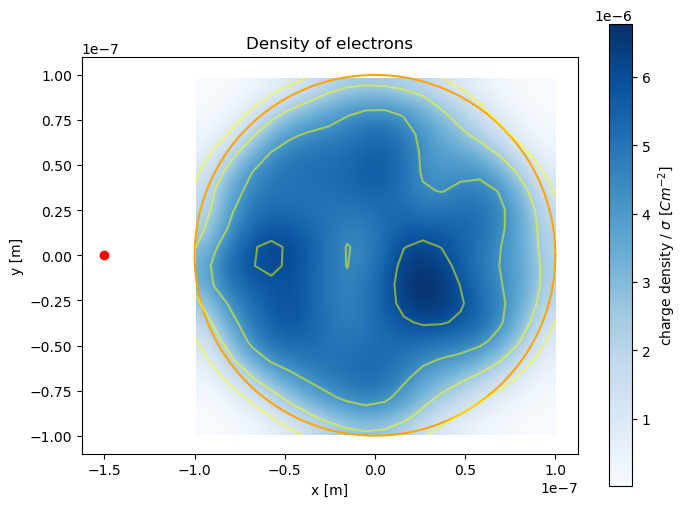

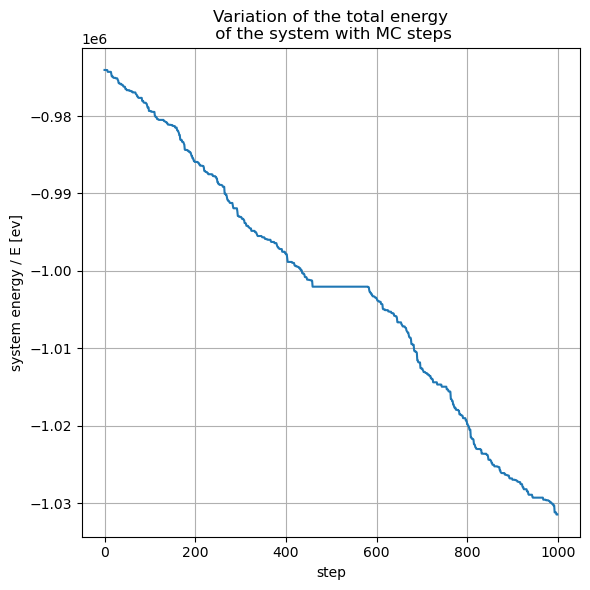

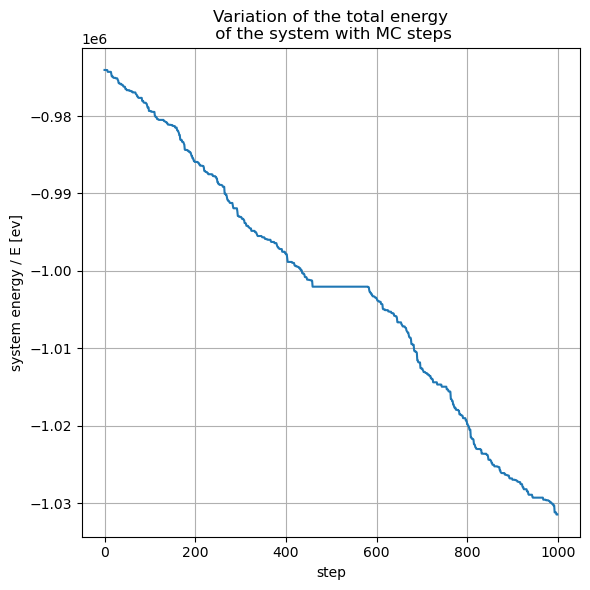

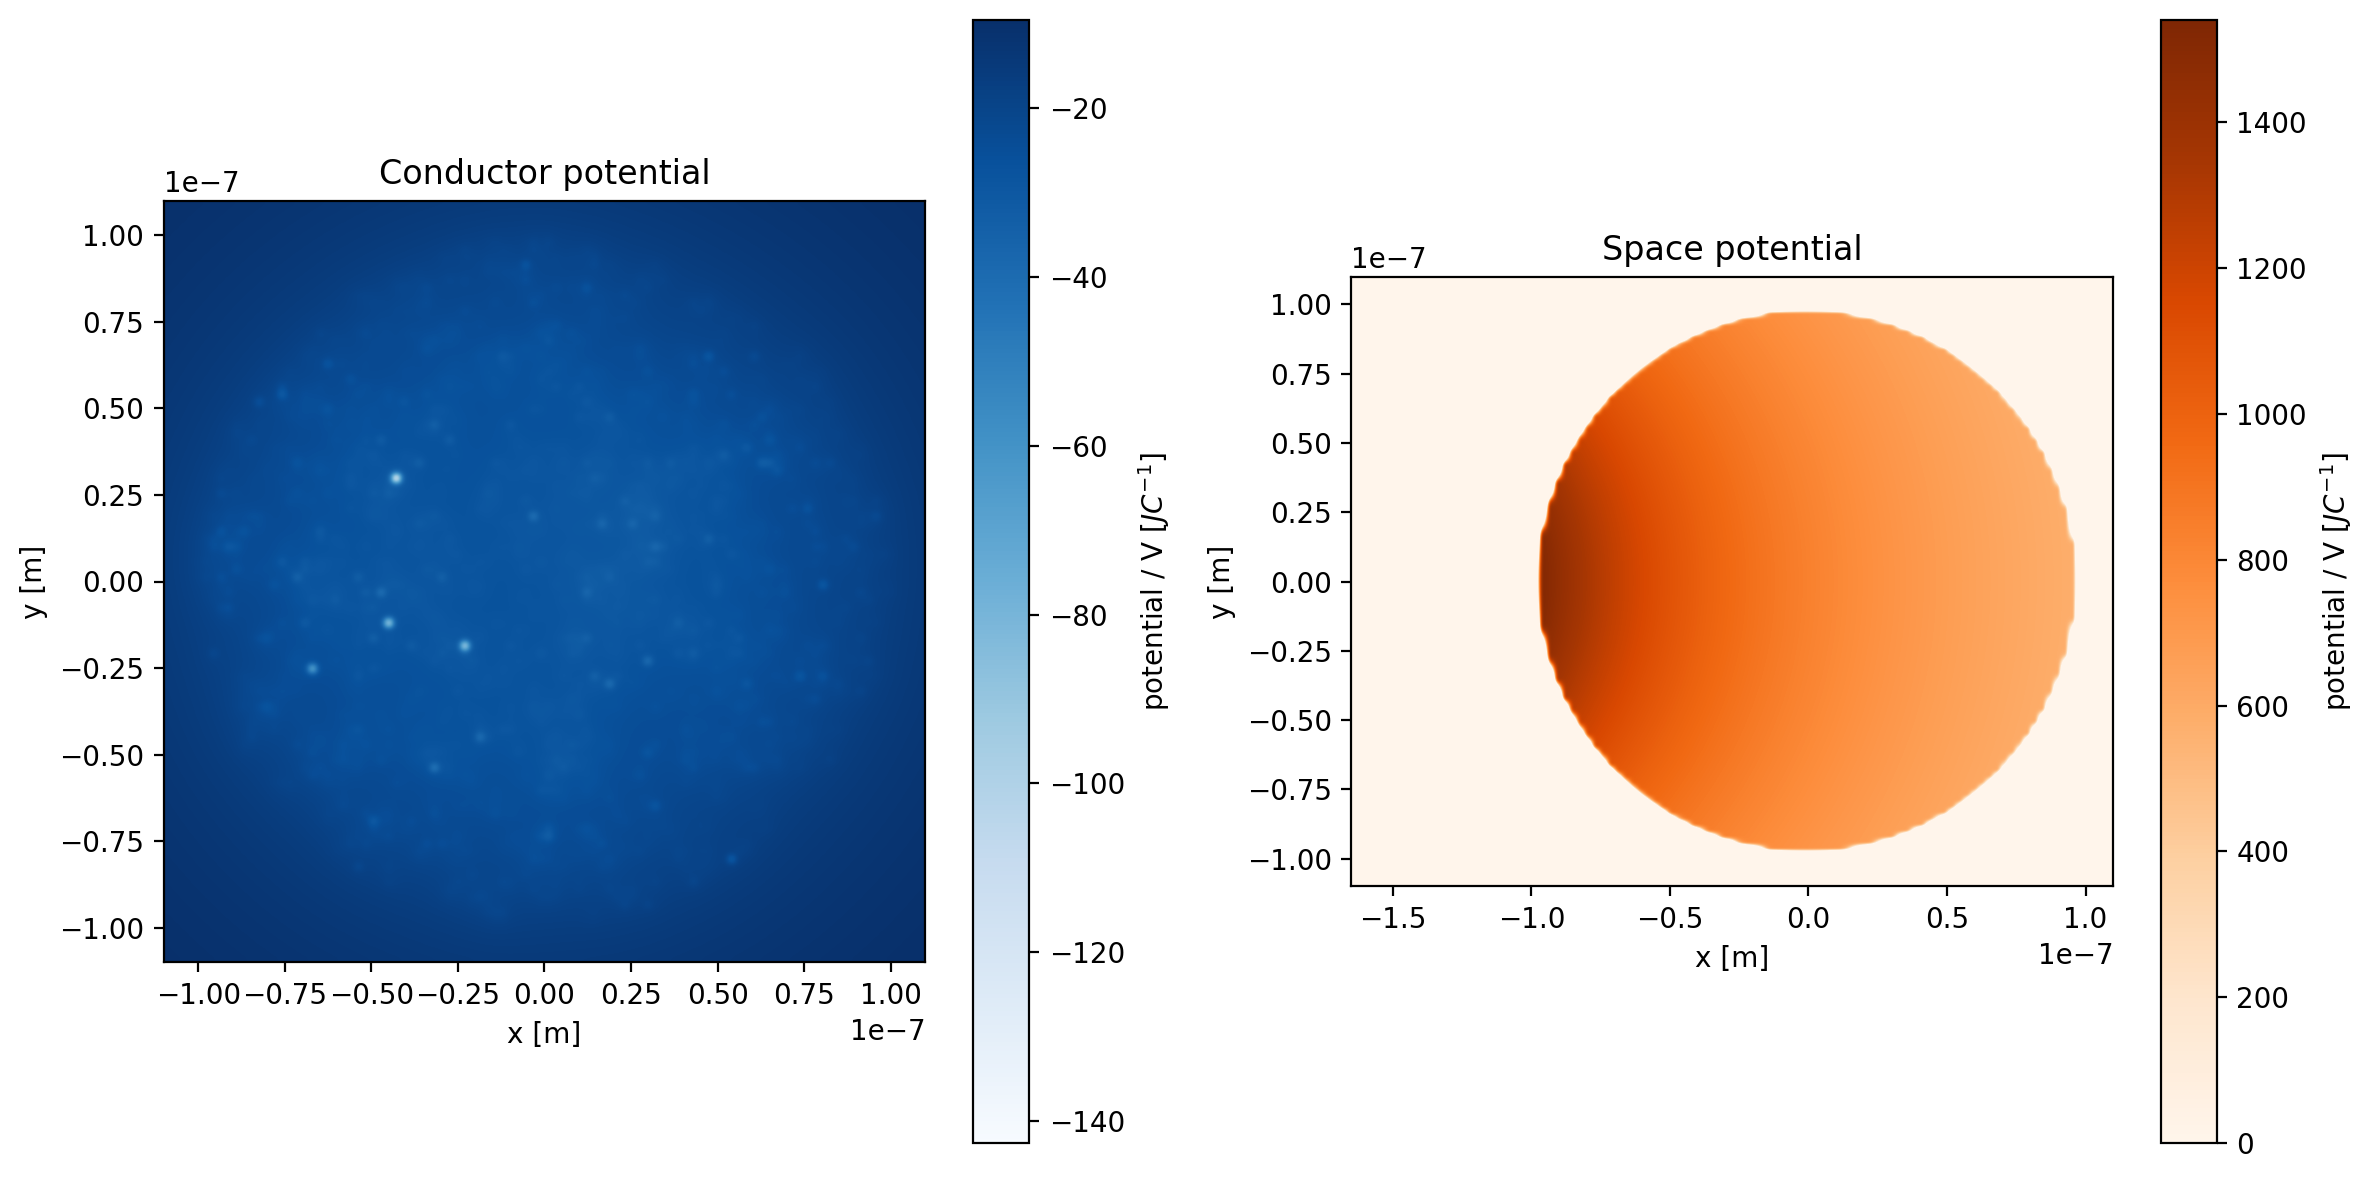

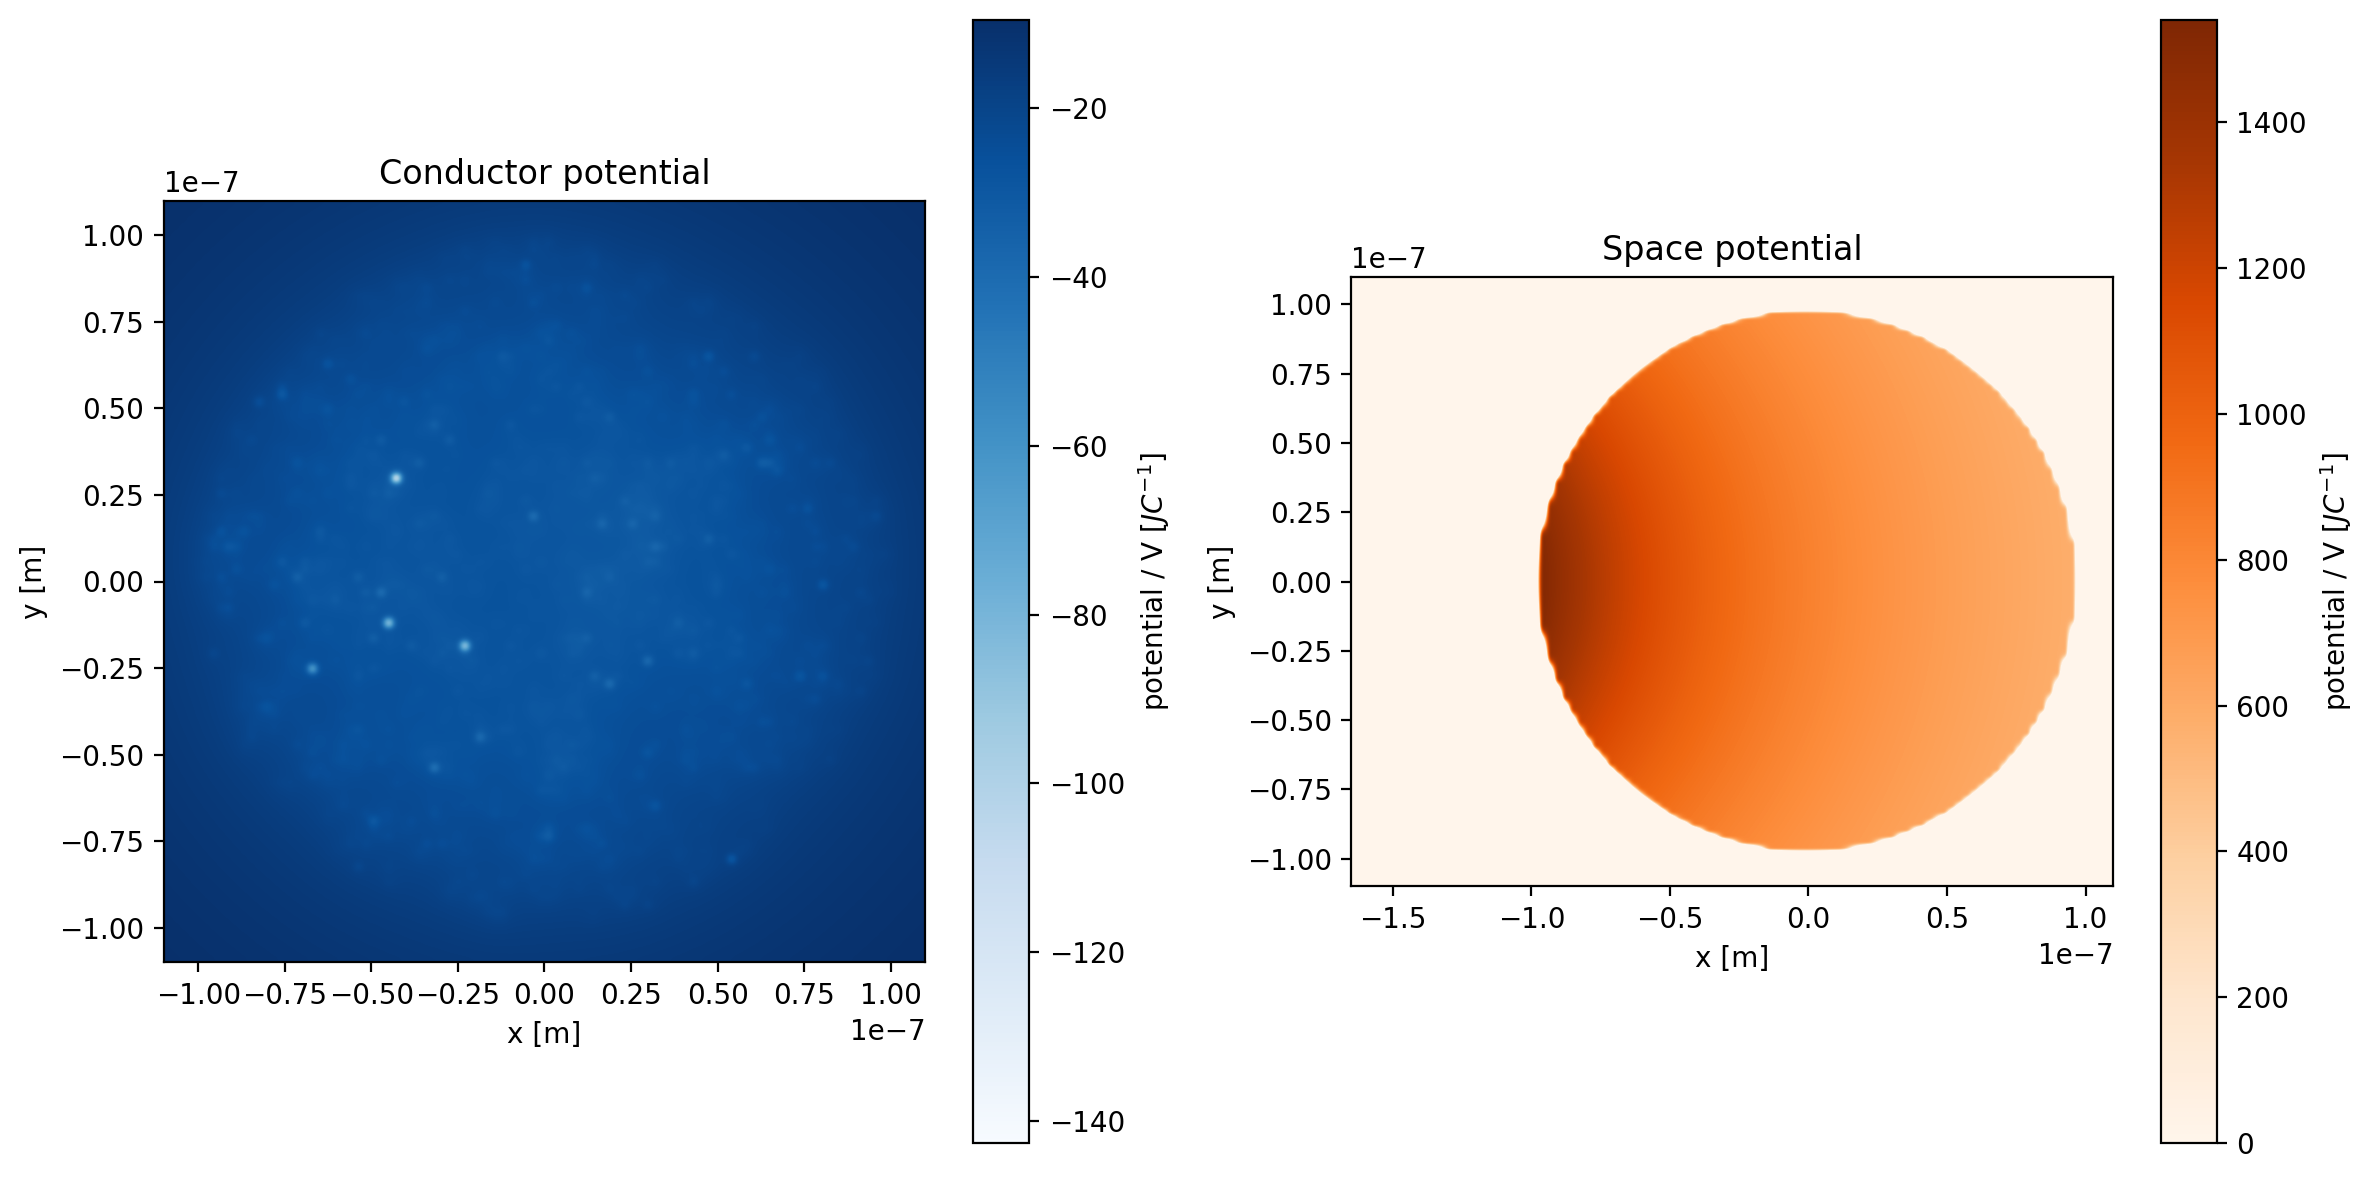

Linear
[-2.17021433e+07  2.00052259e+01]
Power_divergenceResult(statistic=134.06585530888057, pvalue=2.649630102627157e-10)


Inverse linear
[-6.16265098e-08  2.12879658e+01 -1.02388520e-07]
Power_divergenceResult(statistic=123.15113519258144, pvalue=5.762734844296039e-09)

Gaussian
-1.2472299231000003e-09 4.833466116852123e-08
Power_divergenceResult(statistic=130.34345886366128, pvalue=2.600734256742963e-09)
Linear
[-2.17021433e+07  2.00052259e+01]
Power_divergenceResult(statistic=134.06585530888057, pvalue=2.649630102627157e-10)


Inverse linear
[-6.16265098e-08  2.12879658e+01 -1.02388520e-07]
Power_divergenceResult(statistic=123.15113519258144, pvalue=5.762734844296039e-09)

Gaussian
-1.2472299231000003e-09 4.833466116852123e-08
Power_divergenceResult(statistic=130.34345886366128, pvalue=2.600734256742963e-09)


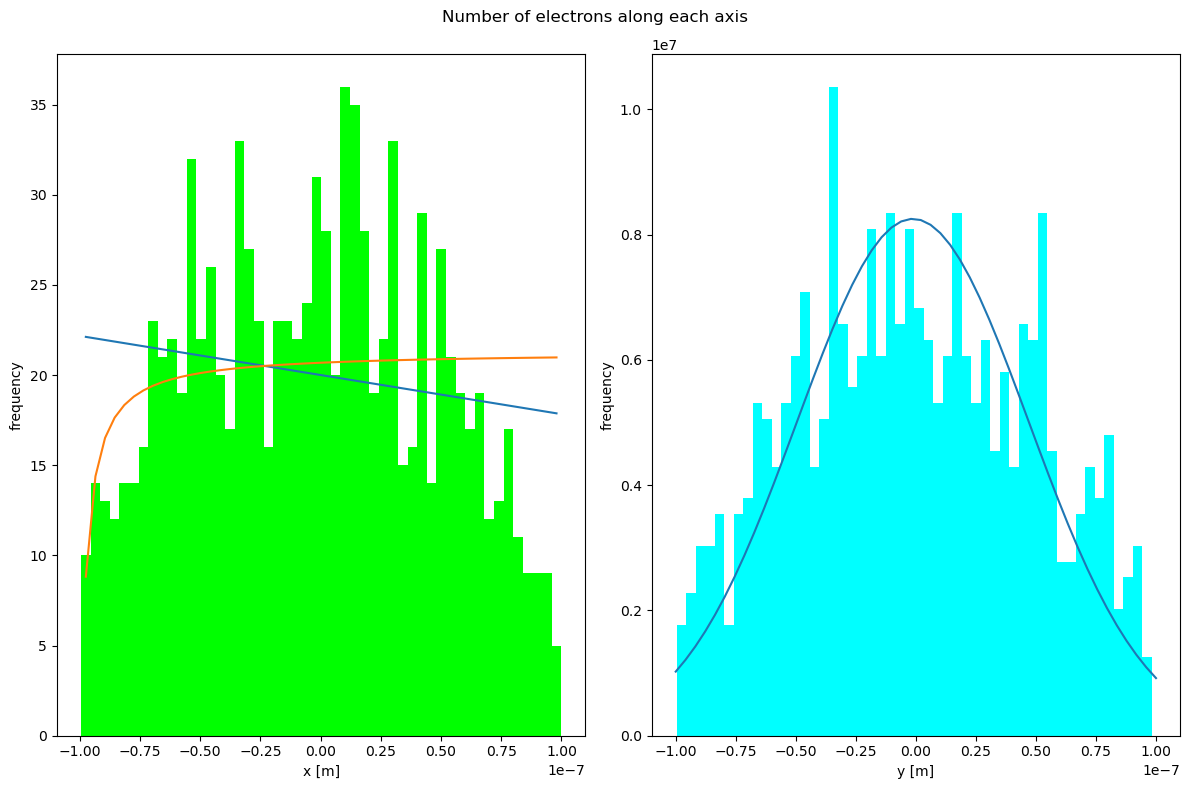

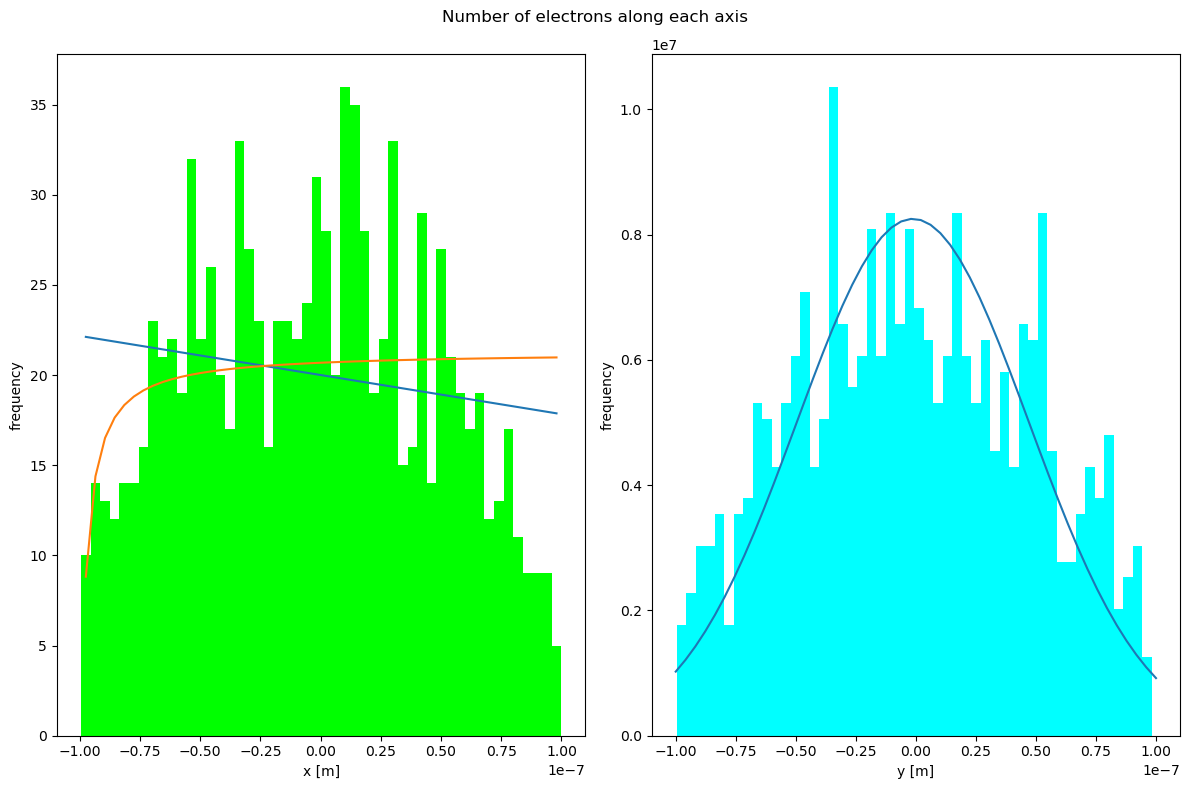

In [11]:
DA = DataAnalysis()

DA.displaySphericalPotential(SphereRadius*1e+4)
DA.displayElectrons()
DA.displayEnergyHistory(len(DA.energyHistory))
DA.potentialProfile(SphereRadius*1e+4)

DA.axisDensity()

### Probability of accepting a change that increases energy by $\Delta E$

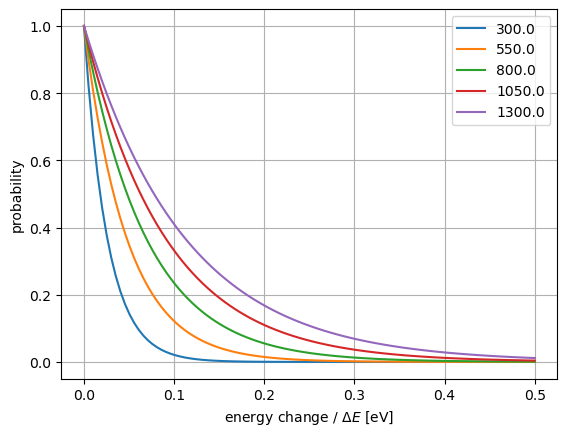

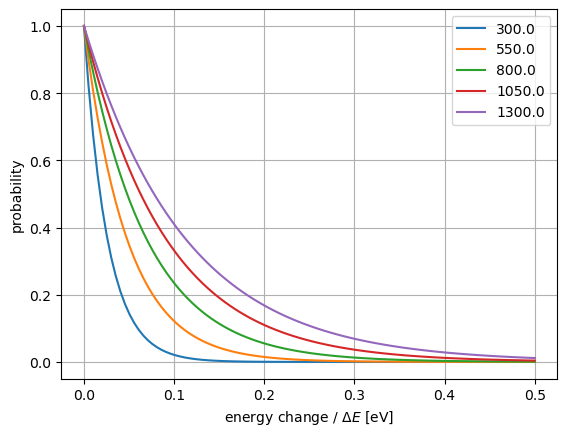

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)


temperatures = np.linspace(Temperature, Temperature + 1000, 5)
dE = np.linspace(0, ElectronCharge/2, 100)
ax.grid()
for T in temperatures:
    ax.plot(dE/ElectronCharge, np.exp(-dE/(Boltzmann*T)), label=T)

# Create appropiate labels
ax.set_xlabel(r'energy change / $\Delta E$ [eV]')
ax.set_ylabel('probability')

ax.legend(loc='best')

plt.show(fig)

References:
* https://lewiscoleblog.com/barnes-hut
* https://people.eecs.berkeley.edu/~demmel/cs267/lecture26/lecture26.html
* https://jheer.github.io/barnes-hut/